In [3]:
import pandas as pd
import ta

# Function to generate technical indicators for a list of datasets
def generate_indicator_data(datasets):
    indicator_data = []

    for dataset in datasets:
        # Read the dataset
        stock_data = pd.read_csv(dataset)
        stock_data = stock_data.iloc[::-1].reset_index(drop=True)

        # Apply indicator calculations
        stock_data = calculate_moving_averages(stock_data)
        stock_data = calculate_stochastic_oscillators(stock_data)
        stock_data = calculate_macd(stock_data)
        stock_data = calculate_rsi(stock_data)
        stock_data = calculate_cci(stock_data)
        stock_data = calculate_ad_oscillator(stock_data)
        stock_data = calculate_momentum(stock_data)

        # Calculate daily price change
        stock_data['Price Change'] = stock_data['Close Price'].diff()

        # Define movement criterion
        stock_data['Movement'] = 0  # Initialize movement column
        stock_data.loc[stock_data['Price Change'] > 0, 'Movement'] = 1

        # Drop rows with NaN values in the 'Movement' column
        stock_data.dropna(subset=['Movement'], inplace=True)

        # Exclude 'Date', 'Price Change', and 'Movement' columns from indicator data
        indicator_data.append(stock_data.drop(columns=['Date', 'Price Change']))

    return indicator_data

# Function to calculate moving averages (SMA and WMA)
def calculate_moving_averages(stock_data):
    stock_data['SMA_10'] = ta.trend.sma_indicator(stock_data['Close Price'], window=10)
    stock_data['WMA_10'] = ta.trend.wma_indicator(stock_data['Close Price'], window=10)
    return stock_data

# Function to calculate stochastic oscillators (STCK%, STCD%, Williams R%)
def calculate_stochastic_oscillators(stock_data):
    stock_data['STCK'] = ta.momentum.stoch(stock_data['High Price'], stock_data['Low Price'], stock_data['Close Price'], window=14)
    stock_data['STCD'] = ta.momentum.stoch_signal(stock_data['High Price'], stock_data['Low Price'], stock_data['Close Price'], window=14)
    stock_data['Williams_R'] = ta.momentum.williams_r(stock_data['High Price'], stock_data['Low Price'], stock_data['Close Price'], lbp=14)
    return stock_data

# Function to calculate MACD
def calculate_macd(stock_data):
    stock_data['MACD'] = ta.trend.macd(stock_data['Close Price'])
    return stock_data

# Function to calculate RSI
def calculate_rsi(stock_data):
    stock_data['RSI'] = ta.momentum.rsi(stock_data['Close Price'])
    return stock_data

# Function to calculate CCI
def calculate_cci(stock_data):
    stock_data['CCI'] = ta.trend.cci(stock_data['High Price'], stock_data['Low Price'], stock_data['Close Price'])
    return stock_data

# Function to calculate A/D oscillator
def calculate_ad_oscillator(stock_data):
    # Calculate A/D oscillator using the provided formula
    stock_data['A/D_Oscillator'] = (stock_data['High Price'] - stock_data['Close Price'].shift(1)) / (stock_data['High Price'] - stock_data['Low Price'])
    return stock_data

# Function to calculate momentum
def calculate_momentum(stock_data):
    stock_data['Momentum'] = ta.momentum.roc(stock_data['Close Price'])
    return stock_data


# Example usage
datasets = ['BHEL.csv', 'NIFTY BANK.csv', 'Sensex.csv', 'TATA.csv']
indicator_data = generate_indicator_data(datasets)

# Print each processed DataFrame
for idx, dataset in enumerate(datasets):
    print(f"\n# Indicator Data for {dataset}\n")
    print(indicator_data[idx])
    print("\n\n")



# Indicator Data for BHEL.csv

      Open Price  High Price  Low Price  Close Price          WAP  \
0        2330.00     2348.00    2306.00      2344.10  2328.830845   
1        2346.00     2352.00    2322.50      2331.05  2332.930338   
2        2325.00     2339.50    2292.30      2306.70  2305.128109   
3        2329.00     2330.05    2282.30      2306.95  2300.062772   
4        2300.00     2306.70    2280.00      2290.60  2290.837787   
...          ...         ...        ...          ...          ...   
2473       34.35       34.50      33.60        33.80    34.071355   
2474       33.85       35.50      33.85        35.20    34.798756   
2475       35.55       35.70      34.35        35.35    35.008764   
2476       36.70       36.70      35.00        35.40    35.524323   
2477       35.20       36.50      35.20        35.90    35.928035   

      No.of Shares  No. of Trades  Total Turnover (Rs.)  Deliverable Quantity  \
0            38184           2566            88924077.0   

In [18]:
import pandas as pd

# Function to convert technical indicators to trend deterministic discrete data
def convert_to_trend_data(indicator_data):
    # Create lagged columns for each technical indicator
    for indicator in ['STCK', 'STCD', 'Williams_R', 'MACD', 'RSI', 'CCI', 'A/D_Oscillator']:
        indicator_data[indicator + '_lag'] = indicator_data[indicator].shift(1)

    # Define the conversion function
    def convert_to_trend(row):
        converted_data = []

        # Moving Averages (SMA_10 and WMA_10)
        if row['Close Price'] > row['SMA_10']:
            converted_data.append(1)
        else:
            converted_data.append(-1)

        if row['Close Price'] > row['WMA_10']:
            converted_data.append(1)
        else:
            converted_data.append(-1)

        # Stochastic Oscillators (STCK, STCD, and Williams_R)
        for indicator in ['STCK', 'STCD', 'Williams_R']:
            if not pd.isnull(row[indicator]) and not pd.isnull(row[indicator + '_lag']):
                if row[indicator] > row[indicator + '_lag']:
                    converted_data.append(1)
                else:
                    converted_data.append(-1)
            else:
                converted_data.append(0)  # Handle missing values by assigning 0

        # MACD
        if not pd.isnull(row['MACD']) and not pd.isnull(row['MACD_lag']):
            if row['MACD'] > row['MACD_lag']:
                converted_data.append(1)
            else:
                converted_data.append(-1)
        else:
            converted_data.append(0)

        # RSI (Relative Strength Index)
        if not pd.isnull(row['RSI']):
            if row['RSI'] > 70:
                converted_data.append(-1)
            elif row['RSI'] < 30:
                converted_data.append(1)
            else:
                if not pd.isnull(row['RSI_lag']):
                    if row['RSI'] > row['RSI_lag']:
                        converted_data.append(1)
                    else:
                        converted_data.append(-1)
                else:
                    converted_data.append(0)
        else:
            converted_data.append(0)

        # CCI (Commodity Channel Index)
        if not pd.isnull(row['CCI']) and not pd.isnull(row['CCI_lag']):
            if row['CCI'] > row['CCI_lag']:
                converted_data.append(1)
            else:
                converted_data.append(-1)
        else:
            converted_data.append(0)

        # A/D Oscillator
        if not pd.isnull(row['A/D_Oscillator']) and not pd.isnull(row['A/D_Oscillator_lag']):
            if row['A/D_Oscillator'] > row['A/D_Oscillator_lag']:
                converted_data.append(1)
            else:
                converted_data.append(-1)
        else:
            converted_data.append(0)

        # Momentum
        if not pd.isnull(row['Momentum']):
            if row['Momentum'] > 0:
                converted_data.append(1)
            else:
                converted_data.append(-1)
        else:
            converted_data.append(0)

        return converted_data

    # Apply the function to the DataFrame
    trend_data = indicator_data.apply(convert_to_trend, axis=1)

    # Define column names for trend data
    indicator_columns = ['SMA_10', 'WMA_10', 'STCK', 'STCD', 'Williams_R', 'MACD', 'RSI', 'CCI', 'A/D_Oscillator', 'Momentum']
    trend_columns = [f"{indicator}_trend" for indicator in indicator_columns]

    # Convert the trend data into a DataFrame with appropriate column names
    trend_data_df = pd.DataFrame(trend_data.values.tolist(), columns=trend_columns)

    # Concatenate the trend data DataFrame with the original stock data
    final_data = pd.concat([indicator_data, trend_data_df], axis=1)

    return final_data

# Loop through indicator data and generate trend data for each dataset
for idx, dataset in enumerate(datasets):
    trend_data = convert_to_trend_data(indicator_data[idx])
    print(f"\n# Trend Data for {dataset}\n")
    print(trend_data)
    print("\n\n")



# Trend Data for BHEL.csv

      Open Price  High Price  Low Price  Close Price          WAP  \
0        2330.00     2348.00    2306.00      2344.10  2328.830845   
1        2346.00     2352.00    2322.50      2331.05  2332.930338   
2        2325.00     2339.50    2292.30      2306.70  2305.128109   
3        2329.00     2330.05    2282.30      2306.95  2300.062772   
4        2300.00     2306.70    2280.00      2290.60  2290.837787   
...          ...         ...        ...          ...          ...   
2473       34.35       34.50      33.60        33.80    34.071355   
2474       33.85       35.50      33.85        35.20    34.798756   
2475       35.55       35.70      34.35        35.35    35.008764   
2476       36.70       36.70      35.00        35.40    35.524323   
2477       35.20       36.50      35.20        35.90    35.928035   

      No.of Shares  No. of Trades  Total Turnover (Rs.)  Deliverable Quantity  \
0            38184           2566            88924077.0       

# SVM for continous data

In [75]:
import warnings 
warnings.filterwarnings('ignore')

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Define dataset names
dataset_names = ["BHEL", "NIFTY BANK", "S&P BSE Sensex", "TATA"]

# Define the parameters grid for SVM
param_grid_poly = {
    'kernel': ['poly'],
    'degree': [1, 2, 3, 4],
    'C': [0.5, 1, 5, 10, 100]
}

param_grid_rbf = {
    'kernel': ['rbf'],
    'gamma': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 10.0],
    'C': [0.5, 1, 5, 10]
}

# Store results
results = []

for idx, (dataset, dataset_name) in enumerate(zip(indicator_data, dataset_names)):
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the SVM model
    svm_model = SVC()

    # Perform grid search for polynomial kernel
    grid_search_poly = GridSearchCV(estimator=svm_model, param_grid=param_grid_poly, cv=5, scoring='accuracy')
    grid_search_poly.fit(X_train_scaled, y_train)
    best_model_poly = grid_search_poly.best_estimator_
    
    # Perform grid search for radial basis kernel
    grid_search_rbf = GridSearchCV(estimator=svm_model, param_grid=param_grid_rbf, cv=5, scoring='accuracy')
    grid_search_rbf.fit(X_train_scaled, y_train)
    best_model_rbf = grid_search_rbf.best_estimator_
    
    # Store results
    results.append({
        'dataset_name': dataset_name,
        'best_model_poly': best_model_poly,
        'best_params_poly': grid_search_poly.best_params_,
        'accuracy_poly': grid_search_poly.best_score_,
        'best_model_rbf': best_model_rbf,
        'best_params_rbf': grid_search_rbf.best_params_,
        'accuracy_rbf': grid_search_rbf.best_score_,
    })

# Store overall accuracies
overall_accuracies = []

# Print results for each dataset
for result in results:
    dataset_name = result['dataset_name']
    
    print(f"Results for {dataset_name}:")
    print("Polynomial Kernel:")
    print(f"Best parameters: {result['best_params_poly']}")
    print(f"Best accuracy: {result['accuracy_poly']}")
    print("Radial Basis Kernel:")
    print(f"Best parameters: {result['best_params_rbf']}")
    print(f"Best accuracy: {result['accuracy_rbf']}")
    
    # Calculate overall accuracy
    overall_accuracy = (result['accuracy_poly'] + result['accuracy_rbf']) / 2
    print(f"Overall accuracy: {overall_accuracy}")
    
    # Append overall accuracy to the list
    overall_accuracies.append(overall_accuracy)

# Print overall accuracies
print("\nAccuracy:")
for result in results:
    dataset_name = result['dataset_name']
    overall_accuracy = (result['accuracy_poly'] + result['accuracy_rbf']) / 2
    print(f"{dataset_name}: {overall_accuracy}")

# Calculate the mean of overall accuracies
ovacc_svm_cont = np.mean(overall_accuracies)

# Print overall accuracy mean
print("\nOverall accuracy:", ovacc_svm_cont)


Results for BHEL:
Polynomial Kernel:
Best parameters: {'C': 100, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.9702261913848815
Radial Basis Kernel:
Best parameters: {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
Best accuracy: 0.8572157341678752
Overall accuracy: 0.9137209627763784
Results for NIFTY BANK:
Polynomial Kernel:
Best parameters: {'C': 100, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.97476655726026
Radial Basis Kernel:
Best parameters: {'C': 0.5, 'gamma': 0.5, 'kernel': 'rbf'}
Best accuracy: 0.8849578912551206
Overall accuracy: 0.9298622242576903
Results for S&P BSE Sensex:
Polynomial Kernel:
Best parameters: {'C': 100, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.9778032211281582
Radial Basis Kernel:
Best parameters: {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
Best accuracy: 0.8940424395084344
Overall accuracy: 0.9359228303182963
Results for TATA:
Polynomial Kernel:
Best parameters: {'C': 100, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.9687224893774014
Radial Basis Kern

# SVM for trend deterministic data

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Define dataset names
dataset_names = ["BHEL", "NIFTY BANK", "S&P BSE Sensex", "TATA"]

# Define the parameters grid for SVM
param_grid_poly = {
    'kernel': ['poly'],
    'degree': [1, 2, 3, 4],
    'C': [0.5, 1, 5, 10, 100]
}

param_grid_rbf = {
    'kernel': ['rbf'],
    'gamma': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 10.0],
    'C': [0.5, 1, 5, 10]
}

# Store results
results = []

for idx, (dataset, dataset_name) in enumerate(zip(trend_data, dataset_names)):
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the SVM model
    svm_model = SVC()

    # Perform grid search for polynomial kernel
    grid_search_poly = GridSearchCV(estimator=svm_model, param_grid=param_grid_poly, cv=5, scoring='accuracy')
    grid_search_poly.fit(X_train_scaled, y_train)
    best_model_poly = grid_search_poly.best_estimator_
    
    # Perform grid search for radial basis kernel
    grid_search_rbf = GridSearchCV(estimator=svm_model, param_grid=param_grid_rbf, cv=5, scoring='accuracy')
    grid_search_rbf.fit(X_train_scaled, y_train)
    best_model_rbf = grid_search_rbf.best_estimator_
    
    # Store results
    results.append({
        'dataset_name': dataset_name,
        'best_model_poly': best_model_poly,
        'best_params_poly': grid_search_poly.best_params_,
        'accuracy_poly': grid_search_poly.best_score_,
        'best_model_rbf': best_model_rbf,
        'best_params_rbf': grid_search_rbf.best_params_,
        'accuracy_rbf': grid_search_rbf.best_score_,
    })

# Store overall accuracies
overall_accuracies = []

# Print results for each dataset
for result in results:
    dataset_name = result['dataset_name']
    
    print(f"Results for {dataset_name}:")
    print("Polynomial Kernel:")
    print(f"Best parameters: {result['best_params_poly']}")
    print(f"Best accuracy: {result['accuracy_poly']}")
    print("Radial Basis Kernel:")
    print(f"Best parameters: {result['best_params_rbf']}")
    print(f"Best accuracy: {result['accuracy_rbf']}")
    
    # Calculate overall accuracy
    overall_accuracy = (result['accuracy_poly'] + result['accuracy_rbf']) / 2
    print(f"Overall accuracy: {overall_accuracy}")
    
    # Append overall accuracy to the list
    overall_accuracies.append(overall_accuracy)

# Print overall accuracies
print("\nAccuracy:")
for result in results:
    dataset_name = result['dataset_name']
    overall_accuracy = (result['accuracy_poly'] + result['accuracy_rbf']) / 2
    print(f"{dataset_name}: {overall_accuracy}")

# Calculate the mean of overall accuracies
ovacc_svm_cont = np.mean(overall_accuracies)

# Print overall accuracy mean
print("\nOverall accuracy:", ovacc_svm_cont)


Results for BHEL:
Polynomial Kernel:
Best parameters: {'C': 100, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.9888965218940029
Radial Basis Kernel:
Best parameters: {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
Best accuracy: 0.9253288553036663
Overall accuracy: 0.9571126885988346
Results for NIFTY BANK:
Polynomial Kernel:
Best parameters: {'C': 100, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.9939457547769889
Radial Basis Kernel:
Best parameters: {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
Best accuracy: 0.9293603541714373
Overall accuracy: 0.961653054474213
Results for S&P BSE Sensex:
Polynomial Kernel:
Best parameters: {'C': 100, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.9964962406015039
Radial Basis Kernel:
Best parameters: {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
Best accuracy: 0.9323947368421053
Overall accuracy: 0.9644454887218046
Results for TATA:
Polynomial Kernel:
Best parameters: {'C': 10, 'degree': 1, 'kernel': 'poly'}
Best accuracy: 0.9914243187542935
Radial Basis Kernel

# Random Forest for continous data

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Define the range of values for the number of trees
ntrees_range = range(10, 201, 10)

# Store results
results_rf = []

for idx, (dataset, dataset_name) in enumerate(zip(indicator_data, dataset_names)):
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size=0.2, random_state=42)

    accuracies = []
    for ntrees in ntrees_range:
        # Define the Random Forest model
        rf_model = RandomForestClassifier(n_estimators=ntrees, random_state=42)

        # Train the model
        rf_model.fit(X_train, y_train)

        # Make predictions
        y_pred = rf_model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store accuracy and parameters
        accuracies.append((accuracy, ntrees))

    # Sort accuracies in descending order
    accuracies.sort(reverse=True)

    # Store the top 3 parameters and accuracies
    top_params = accuracies[:3]

    # Print results for the current dataset
    print(f"Results for {dataset_name}:")
    for acc, params in top_params:
        print(f"Number of trees: {params}, Accuracy: {acc}")

    # Store the results for the current dataset
    results_rf.append({
        'dataset_name': dataset_name,
        'top_params': top_params
    })

# Calculate overall accuracy
overall_accuracy_rf = np.mean([acc for dataset_result in results_rf for acc, _ in dataset_result['top_params']])

# Print overall accuracy
print("\nOverall accuracy for Random Forest:", overall_accuracy_rf)


Results for BHEL:
Number of trees: 40, Accuracy: 0.9455645161290323
Number of trees: 30, Accuracy: 0.9455645161290323
Number of trees: 120, Accuracy: 0.9415322580645161
Results for NIFTY BANK:
Number of trees: 180, Accuracy: 0.905241935483871
Number of trees: 130, Accuracy: 0.905241935483871
Number of trees: 200, Accuracy: 0.9032258064516129
Results for S&P BSE Sensex:
Number of trees: 20, Accuracy: 0.936
Number of trees: 30, Accuracy: 0.934
Number of trees: 10, Accuracy: 0.932
Results for TATA:
Number of trees: 100, Accuracy: 0.9536290322580645
Number of trees: 90, Accuracy: 0.9536290322580645
Number of trees: 80, Accuracy: 0.9536290322580645

Overall accuracy for Random Forest: 0.9341048387096773


# Random Forest for trend deterministic data 

In [72]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': list(range(10, 201, 10))
}

# Store results
results_rf = []

# Function to train Random Forest model
def train_rf(X_train, y_train, params):
    # Define the Random Forest model
    rf_model = RandomForestClassifier(**params)

    # Train the model
    rf_model.fit(X_train, y_train)
    return rf_model

# Function to perform grid search and get top parameters
def get_top_parameters(X_train, y_train):
    # Perform grid search
    grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(max_depth=1), param_grid=param_grid_rf, cv=5, scoring='accuracy')
    grid_search_rf.fit(X_train, y_train)
    
    # Get the top three parameters and their mean test score
    top_params = grid_search_rf.cv_results_['params'][:3]
    top_scores = grid_search_rf.cv_results_['mean_test_score'][:3]
    
    return top_params, top_scores

for idx, (dataset, dataset_name) in enumerate(zip(trend_data, dataset_names)):
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)
    
    # Split the dataset into training and testing sets
    X_train, _, y_train, _ = train_test_split(X_filled, y, test_size=0.3, random_state=42)
    
    # Get top parameters
    top_params, top_scores = get_top_parameters(X_train, y_train)
    
    # Store results
    results_rf.append({
        'dataset_name': dataset_name,
        'top_params': top_params,
        'top_scores': top_scores
    })

# Print top three parameters for each dataset
print("\nTop three parameters for each dataset:")
for result in results_rf:
    print(f"\nDataset: {result['dataset_name']}")
    for params, score in zip(result['top_params'], result['top_scores']):
        print(f"Parameters: {params}, Accuracy: {score}")

# Calculate accuracy for each dataset
dataset_accuracies = [np.max(result['top_scores']) for result in results_rf]

# Print accuracy for each dataset
print("\nAccuracy for each dataset:")
for dataset_name, accuracy in zip(dataset_names, dataset_accuracies):
    print(f"{dataset_name}: Accuracy = {accuracy}")

# Calculate overall accuracy of the model
overall_accuracy_rf = np.mean(dataset_accuracies)

# Print overall accuracy
print("\nOverall accuracy for Random Forest model:", overall_accuracy_rf)



Top three parameters for each dataset:

Dataset: BHEL
Parameters: {'n_estimators': 10}, Accuracy: 0.9625243624127533
Parameters: {'n_estimators': 20}, Accuracy: 0.9740050973663607
Parameters: {'n_estimators': 30}, Accuracy: 0.9792323965950924

Dataset: NIFTY BANK
Parameters: {'n_estimators': 10}, Accuracy: 0.9711815561959654
Parameters: {'n_estimators': 20}, Accuracy: 0.9596375206143491
Parameters: {'n_estimators': 30}, Accuracy: 0.9763488864086888

Dataset: S&P BSE Sensex
Parameters: {'n_estimators': 10}, Accuracy: 0.9541874744167007
Parameters: {'n_estimators': 20}, Accuracy: 0.9839754400327466
Parameters: {'n_estimators': 30}, Accuracy: 0.9839541547277937

Dataset: TATA
Parameters: {'n_estimators': 10}, Accuracy: 0.9901884026586263
Parameters: {'n_estimators': 20}, Accuracy: 0.9671353134213989
Parameters: {'n_estimators': 30}, Accuracy: 0.9913544668587896

Accuracy for each dataset:
BHEL: Accuracy = 0.9792323965950924
NIFTY BANK: Accuracy = 0.9763488864086888
S&P BSE Sensex: Accura

# Naive bayes for continous data

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define dataset names
dataset_names = ["BHEL", "NIFTY BANK", "S&P BSE Sensex", "TATA"]

# Store results
results_nb = []

# Function to train Naive Bayes model
def train_nb(X_train, y_train):
    # Define the Naive Bayes model
    nb_model = GaussianNB()

    # Train the model
    nb_model.fit(X_train, y_train)
    return nb_model

# Loop over each dataset
for idx, (dataset, dataset_name) in enumerate(zip(indicator_data, dataset_names)):
    # Select numeric columns
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train Naive Bayes model
    nb_model = train_nb(X_train, y_train)

    # Make predictions
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results_nb.append({
        'dataset_name': dataset_name,
        'accuracy': accuracy
    })

# Print accuracy for each dataset
print("Accuracy for Naive Bayes:")
for result in results_nb:
    print(f"{result['dataset_name']}: Accuracy = {result['accuracy']}")

# Calculate overall accuracy
overall_accuracy_nb = sum(result['accuracy'] for result in results_nb) / len(results_nb)

# Print overall accuracy
print("\nOverall accuracy for Naive Bayes model:", overall_accuracy_nb)


Accuracy for Naive Bayes:
BHEL: Accuracy = 0.7560483870967742
NIFTY BANK: Accuracy = 0.7056451612903226
S&P BSE Sensex: Accuracy = 0.76
TATA: Accuracy = 0.7056451612903226

Overall accuracy for Naive Bayes model: 0.7318346774193548


# Naive Bayes for trend deterministic data

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define dataset names
dataset_names = ["BHEL", "NIFTY BANK", "S&P BSE Sensex", "TATA"]

# Store results
results_nb = []

# Function to train Naive Bayes model
def train_nb(X_train, y_train):
    # Define the Naive Bayes model
    nb_model = GaussianNB()

    # Train the model
    nb_model.fit(X_train, y_train)
    return nb_model

# Loop over each dataset
for idx, (dataset, dataset_name) in enumerate(zip(trend_data, dataset_names)):
    # Select numeric columns
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train Naive Bayes model
    nb_model = train_nb(X_train, y_train)

    # Make predictions
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results_nb.append({
        'dataset_name': dataset_name,
        'accuracy': accuracy
    })

# Print accuracy for each dataset
print("Accuracy for Naive Bayes:")
for result in results_nb:
    print(f"{result['dataset_name']}: Accuracy = {result['accuracy']}")

# Calculate overall accuracy
overall_accuracy_nb = sum(result['accuracy'] for result in results_nb) / len(results_nb)

# Print overall accuracy
print("\nOverall accuracy for Naive Bayes model:", overall_accuracy_nb)


Accuracy for Naive Bayes:
BHEL: Accuracy = 0.9375
NIFTY BANK: Accuracy = 0.9717741935483871
S&P BSE Sensex: Accuracy = 0.968
TATA: Accuracy = 0.9657258064516129

Overall accuracy for Naive Bayes model: 0.96075


# ANN for continous data

In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.impute import SimpleImputer
from tensorflow.keras.callbacks import EarlyStopping

# Define function to create ANN model
def create_model(input_dim, n_neurons, lr, momentum, dropout_rate):
    model = Sequential([
        Dense(n_neurons, input_dim=input_dim, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = SGD(lr=lr, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define parameter grid
param_grid = {
    'n_neurons': [10, 20,30,40],  # Reduced number of neurons
    'epochs': [10,20,30,40],      # Reduced number of epochs
    'lr': [0.01],           # Lower learning rate
    'momentum': [0.1,0.2,0.3],      # Lower momentum
    'dropout_rate': [0.5]   # Higher dropout rate
}

# Initialize variables
dataset_names = ["BHEL", "NIFTY BANK", "S&P BSE Sensex", "TATA"]
best_params_per_dataset = {}
dataset_accuracies = {}
overall_accuracies = []

# Iterate over datasets
for idx, dataset in enumerate(indicator_data):
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Initialize variables for this dataset
    dataset_accuracy = 0
    top_three_params = [{'accuracy': 0.0}, {'accuracy': 0.0}, {'accuracy': 0.0}]

    # Iterate over parameter grid
    for n_neurons, epochs, lr, momentum, dropout_rate in product(param_grid['n_neurons'], param_grid['epochs'], param_grid['lr'], param_grid['momentum'], param_grid['dropout_rate']):
        # Create and compile model
        model = create_model(X_train.shape[1], n_neurons, lr, momentum, dropout_rate)

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=3, restore_best_weights=True)

        # Train model
        model.fit(X_train, y_train, epochs=epochs, verbose=0, callbacks=[early_stopping])

        # Evaluate model
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)

        # Update dataset accuracy
        dataset_accuracy = max(dataset_accuracy, accuracy)

        # Update top three parameters
        for i, params in enumerate(top_three_params):
            if accuracy > params['accuracy']:
                for j in range(2, i, -1):
                    top_three_params[j] = top_three_params[j - 1]
                top_three_params[i] = {'n_neurons': n_neurons, 'epochs': epochs, 'lr': lr, 'momentum': momentum, 'dropout_rate': dropout_rate, 'accuracy': accuracy}
                break

    # Save top three best parameters for this dataset
    best_params_per_dataset[dataset_names[idx]] = top_three_params

    # Store dataset accuracy
    dataset_accuracies[dataset_names[idx]] = dataset_accuracy
    overall_accuracies.append(dataset_accuracy)

# Calculate overall accuracy of the model
overall_accuracy = np.mean(overall_accuracies)

# Print top three best parameters for each dataset
print("\nTop three best parameters for each dataset:")
for dataset, params in best_params_per_dataset.items():
    print(f"Dataset: {dataset}")
    for i, param in enumerate(params, start=1):
        print(f"Rank {i}: {param}")

# Print accuracy of each dataset
print("\nAccuracy of each dataset:")
for dataset, accuracy in dataset_accuracies.items():
    print(f"Dataset: {dataset}, Accuracy: {accuracy}")

# Print overall accuracy of the model
print(f"\nOverall Accuracy of the model: {overall_accuracy}")


24/24 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 37.
Epoch 40: early stopping
24/24 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 31.
Epoch 34: early stopping
24/24 [==============================] - 0s 4ms/step
Restoring model weights from the end of the best epoch: 23.
Epoch 26: early stopping
24/24 [==============================] - 0s 4ms/step
Restoring model weights from the end of the best epoch: 36.
Epoch 39: early stopping
24/24 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 32.
Epoch 35: early stopping
24/24 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 31.
Epoch 34: early stopping
24/24 [==============================] - 0s 6ms/step
Restoring model weights from the end of the best epoch: 18.
Epoch 21: early stopping
24/24 [===========================

# ANN for trend deterministic data

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.impute import SimpleImputer
from tensorflow.keras.callbacks import EarlyStopping

# Define function to create ANN model
def create_model(input_dim, n_neurons, lr, momentum, dropout_rate):
    model = Sequential([
        Dense(n_neurons, input_dim=input_dim, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = SGD(lr=lr, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define parameter grid
param_grid = {
    'n_neurons': [10, 20,30,40],  # Reduced number of neurons
    'epochs': [10,20,30,40],      # Reduced number of epochs
    'lr': [0.01],           # Lower learning rate
    'momentum': [0.1,0.2,0.3],      # Lower momentum
    'dropout_rate': [0.5]   # Higher dropout rate
}

# Initialize variables
dataset_names = ["BHEL", "NIFTY BANK", "S&P BSE Sensex", "TATA"]
best_params_per_dataset = {}
dataset_accuracies = {}
overall_accuracies = []

# Iterate over datasets
for idx, dataset in enumerate(trend_data):
    numeric_columns = dataset.drop(['Close Price', 'Movement'], axis=1).select_dtypes(include=np.number).columns
    X = dataset[numeric_columns]
    y = dataset['Movement']
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_filled = imputer.fit_transform(X)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Initialize variables for this dataset
    dataset_accuracy = 0
    top_three_params = [{'accuracy': 0.0}, {'accuracy': 0.0}, {'accuracy': 0.0}]

    # Iterate over parameter grid
    for n_neurons, epochs, lr, momentum, dropout_rate in product(param_grid['n_neurons'], param_grid['epochs'], param_grid['lr'], param_grid['momentum'], param_grid['dropout_rate']):
        # Create and compile model
        model = create_model(X_train.shape[1], n_neurons, lr, momentum, dropout_rate)

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=3, restore_best_weights=True)

        # Train model
        model.fit(X_train, y_train, epochs=epochs, verbose=0, callbacks=[early_stopping])

        # Evaluate model
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)

        # Update dataset accuracy
        dataset_accuracy = max(dataset_accuracy, accuracy)

        # Update top three parameters
        for i, params in enumerate(top_three_params):
            if accuracy > params['accuracy']:
                for j in range(2, i, -1):
                    top_three_params[j] = top_three_params[j - 1]
                top_three_params[i] = {'n_neurons': n_neurons, 'epochs': epochs, 'lr': lr, 'momentum': momentum, 'dropout_rate': dropout_rate, 'accuracy': accuracy}
                break

    # Save top three best parameters for this dataset
    best_params_per_dataset[dataset_names[idx]] = top_three_params

    # Store dataset accuracy
    dataset_accuracies[dataset_names[idx]] = dataset_accuracy
    overall_accuracies.append(dataset_accuracy)

# Calculate overall accuracy of the model
overall_accuracy = np.mean(overall_accuracies)

# Print top three best parameters for each dataset
print("\nTop three best parameters for each dataset:")
for dataset, params in best_params_per_dataset.items():
    print(f"Dataset: {dataset}")
    for i, param in enumerate(params, start=1):
        print(f"Rank {i}: {param}")

# Print accuracy of each dataset
print("\nAccuracy of each dataset:")
for dataset, accuracy in dataset_accuracies.items():
    print(f"Dataset: {dataset}, Accuracy: {accuracy}")

# Print overall accuracy of the model
print(f"\nOverall Accuracy of the model: {overall_accuracy}")


24/24 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 23.
Epoch 26: early stopping
24/24 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 24.
Epoch 27: early stopping
24/24 [==============================] - 0s 4ms/step
Restoring model weights from the end of the best epoch: 30.
Epoch 33: early stopping
24/24 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 34.
Epoch 37: early stopping
24/24 [==============================] - 0s 8ms/step
Restoring model weights from the end of the best epoch: 19.
Epoch 22: early stopping
24/24 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 15.
Epoch 18: early stopping
24/24 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 19.
Epoch 22: early stopping
24/24 [===========================

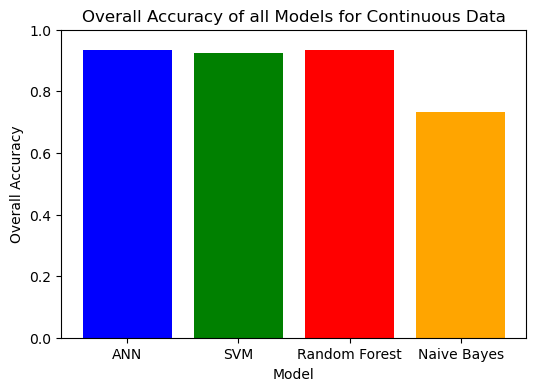

In [86]:
import matplotlib.pyplot as plt

# Overall accuracies for each model
overall_accuracies = [0.9353145161290322, 0.9254535277205302, 0.9341048387096773, 0.7318346774193548]

# Model names
model_names = ['ANN','SVM','Random Forest', 'Naive Bayes']

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(model_names, overall_accuracies, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Model')
plt.ylabel('Overall Accuracy')
plt.title('Overall Accuracy of all Models for Continuous Data')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better visualization
#plt.grid(axis='y')
plt.show()


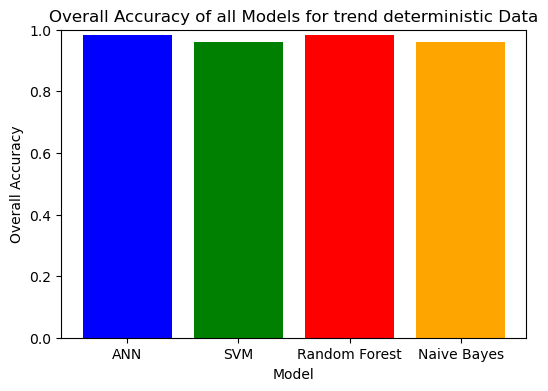

In [89]:
import matplotlib.pyplot as plt

# Overall accuracies for each model
overall_accuracies = [overall_accuracy, ovacc_svm_cont, overall_accuracy_rf, 0.96075]

# Model names
model_names = ['ANN','SVM','Random Forest', 'Naive Bayes']

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(model_names, overall_accuracies, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Model')
plt.ylabel('Overall Accuracy')
plt.title('Overall Accuracy of all Models for trend deterministic Data')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better visualization
#plt.grid(axis='y')
plt.show()
